📌 week9 과제는 **9주차의 LSTM Model 및  GRU Model 실습**으로 구성되어 있습니다.

📌 위키독스의 딥러닝을 이용한 자연어 처리 입문 교재 실습 등의 문서 자료로 구성되어 있는 과제입니다. 

📌 안내된 링크에 맞추어 **직접 코드를 따라 치면서 (필사)** 해당 nlp task 의 기본적인 라이브러리와 메서드를 숙지해보시면 좋을 것 같습니다😊 필수라고 체크한 부분은 과제에 반드시 포함시켜주시고, 선택으로 체크한 부분은 자율적으로 스터디 하시면 됩니다.

📌 궁금한 사항은 깃허브 이슈나, 카톡방, 세션 발표 시작 이전 시간 등을 활용하여 자유롭게 공유해주세요!

In [ ]:
import nltk
# nltk colab 환경에서 실행시 필요한 코드입니다. 
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

### 1️⃣ **LSTM Model**

👀 **내용 복습** 
* LSTM Model은 기존의 RNN이 비교적 짧은 sequence에 대해서만 효과를 보이던 단점을 극복하여 긴 sequence의 입력을 처리하는데 탁월한 성능을 보입니다.

* LSTM Model 설명 참고 자료
 * [장단기 메모리(Long Short-Term Memory, LSTM)](https://wikidocs.net/22888)
 * [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
 * [RNN과 LSTM을 이해해보자!](https://ratsgo.github.io/natural%20language%20processing/2017/03/09/rnnlstm/)

🥰 **1-(1)~(4)의 실습 중 2개 이상 택해서 실습하시면 됩니다.**

🔹 1-(1) **텍스트 생성**하기

* 문맥을 반영하여 텍스트를 생성하는 모델을 만들어 보겠습니다.

📌 [LSTM을 이용한 텍스트 생성](https://wikidocs.net/45101) 
👉 **1. RNN을 이용하여 텍스트 생성하기**는 안 하셔도 무방합니다.







# **1. RNN을 이용하여 텍스트 생성하기**

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [ ]:
text = """경마장에 있는 말이 뛰고 있다\n
그의 말이 법이다\n
가는 말이 고와야 오는 말이 곱다\n"""

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([text])
vocab_size = len(tokenizer.word_index) + 1
print('단어 집합의 크기 : %d' % vocab_size)

In [ ]:
print(tokenizer.word_index)

In [ ]:
sequences = list()
for line in text.split('\n'): # 줄바꿈 문자를 기준으로 문장 토큰화
    encoded = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(encoded)):
        sequence = encoded[:i+1]
        sequences.append(sequence)

print('학습에 사용할 샘플의 개수: %d' % len(sequences))

In [ ]:
print(sequences)

In [ ]:
max_len = max(len(l) for l in sequences) # 모든 샘플에서 길이가 가장 긴 샘플의 길이 출력
print('샘플의 최대 길이 : {}'.format(max_len))

In [ ]:
sequences = pad_sequences(sequences, maxlen=max_len, padding='pre')

In [ ]:
print(sequences)

In [ ]:
sequences = np.array(sequences)
X = sequences[:,:-1]
y = sequences[:,-1]

In [ ]:
print(X)

In [ ]:
print(y)

In [ ]:
y = to_categorical(y, num_classes=vocab_size)

In [ ]:
print(y)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, SimpleRNN

In [ ]:
embedding_dim = 10
hidden_units = 32

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(SimpleRNN(hidden_units))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, y, epochs=200, verbose=2)

In [ ]:
def sentence_generation(model, tokenizer, current_word, n): # 모델, 토크나이저, 현재 단어, 반복할 횟수
    init_word = current_word
    sentence = ''

    # n번 반복
    for _ in range(n):
        # 현재 단어에 대한 정수 인코딩과 패딩
        encoded = tokenizer.texts_to_sequences([current_word])[0]
        encoded = pad_sequences([encoded], maxlen=5, padding='pre')
        # 입력한 X(현재 단어)에 대해서 Y를 예측하고 Y(예측한 단어)를 result에 저장.
        result = model.predict(encoded, verbose=0)
        result = np.argmax(result, axis=1)

        for word, index in tokenizer.word_index.items(): 
            # 만약 예측한 단어와 인덱스와 동일한 단어가 있다면 break
            if index == result:
                break

        # 현재 단어 + ' ' + 예측 단어를 현재 단어로 변경
        current_word = current_word + ' '  + word

        # 예측 단어를 문장에 저장
        sentence = sentence + ' ' + word

    sentence = init_word + sentence
    return sentence

In [ ]:
print(sentence_generation(model, tokenizer, '경마장에', 4))

In [ ]:
print(sentence_generation(model, tokenizer, '그의', 2))

In [ ]:
print(sentence_generation(model, tokenizer, '가는', 5))

# **2. LSTM을 이용하여 텍스트 생성하기**

In [ ]:
import pandas as pd
import numpy as np
from string import punctuation

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [ ]:
df = pd.read_csv('ArticlesApril2018.csv')
df.head()

In [ ]:
print('열의 개수: ',len(df.columns))
print(df.columns)

In [ ]:
print(df['headline'].isnull().values.any())

In [ ]:
headline = []
# 헤드라인의 값들을 리스트로 저장
headline.extend(list(df.headline.values)) 
headline[:5]

In [ ]:
print('총 샘플의 개수 : {}'.format(len(headline)))

In [ ]:
headline = [word for word in headline if word != "Unknown"]
print('노이즈값 제거 후 샘플의 개수 : {}'.format(len(headline)))

In [ ]:
headline[:5]

In [ ]:
def repreprocessing(raw_sentence):
    preproceseed_sentence = raw_sentence.encode("utf8").decode("ascii",'ignore')
    # 구두점 제거와 동시에 소문자화
    return ''.join(word for word in preproceseed_sentence if word not in punctuation).lower()

preprocessed_headline = [repreprocessing(x) for x in headline]
preprocessed_headline[:5]

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(preprocessed_headline)
vocab_size = len(tokenizer.word_index) + 1
print('단어 집합의 크기 : %d' % vocab_size)

In [ ]:
sequences = list()

for sentence in preprocessed_headline:

    # 각 샘플에 대한 정수 인코딩
    encoded = tokenizer.texts_to_sequences([sentence])[0] 
    for i in range(1, len(encoded)):
        sequence = encoded[:i+1]
        sequences.append(sequence)

sequences[:11]

In [ ]:
index_to_word = {}
for key, value in tokenizer.word_index.items(): # 인덱스를 단어로 바꾸기 위해 index_to_word를 생성
    index_to_word[value] = key

print('빈도수 상위 582번 단어 : {}'.format(index_to_word[582]))

In [ ]:
max_len = max(len(l) for l in sequences)
print('샘플의 최대 길이 : {}'.format(max_len))

In [ ]:
sequences = pad_sequences(sequences, maxlen=max_len, padding='pre')
print(sequences[:3])

In [ ]:
sequences = np.array(sequences)
X = sequences[:,:-1]
y = sequences[:,-1]

In [ ]:
print(X[:3])

In [ ]:
print(y[:3])

In [ ]:
y = to_categorical(y, num_classes=vocab_size)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM

In [ ]:
embedding_dim = 10
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, y, epochs=200, verbose=2)

In [ ]:
def sentence_generation(model, tokenizer, current_word, n): # 모델, 토크나이저, 현재 단어, 반복할 횟수
    init_word = current_word
    sentence = ''

    # n번 반복
    for _ in range(n):
        encoded = tokenizer.texts_to_sequences([current_word])[0]
        encoded = pad_sequences([encoded], maxlen=max_len-1, padding='pre')

        # 입력한 X(현재 단어)에 대해서 y를 예측하고 y(예측한 단어)를 result에 저장.
        result = model.predict(encoded, verbose=0)
        result = np.argmax(result, axis=1)

        for word, index in tokenizer.word_index.items(): 
            # 만약 예측한 단어와 인덱스와 동일한 단어가 있다면
            if index == result:
                break

        # 현재 단어 + ' ' + 예측 단어를 현재 단어로 변경
        current_word = current_word + ' '  + word

        # 예측 단어를 문장에 저장
        sentence = sentence + ' ' + word

    sentence = init_word + sentence
    return sentence

In [ ]:
print(sentence_generation(model, tokenizer, 'i', 10))

In [ ]:
print(sentence_generation(model, tokenizer, 'how', 10))

🔹 1-(2) **로이터 뉴스 분류**하기
* 로이터 뉴스 데이터를 LSTM을 이용하여 텍스트 분류를 진행하겠습니다.

📌 [LSTM을 이용한 로이터 뉴스 분류](https://wikidocs.net/22933) 👉 **1. 로이터 뉴스 데이터에 대한 이해**는 안 하셔도 무방합니다.

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import reuters

In [ ]:
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

print('훈련용 뉴스 기사 : {}'.format(len(X_train)))
print('테스트용 뉴스 기사 : {}'.format(len(X_test)))
num_classes = len(set(y_train))
print('카테고리 : {}'.format(num_classes))

In [ ]:
print('첫번째 훈련용 뉴스 기사 :',X_train[0])
print('첫번째 훈련용 뉴스 기사의 레이블 :',y_train[0])

In [ ]:
print('뉴스 기사의 최대 길이 :{}'.format(max(len(sample) for sample in X_train)))
print('뉴스 기사의 평균 길이 :{}'.format(sum(map(len, X_train))/len(X_train)))

plt.hist([len(sample) for sample in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(12,5)
sns.countplot(y_train)

In [ ]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 레이블에 대한 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

In [ ]:
word_to_index = reuters.get_word_index()
print(word_to_index)

In [ ]:
index_to_word = {}
for key, value in word_to_index.items():
    index_to_word[value+3] = key

In [ ]:
print('빈도수 상위 1번 단어 : {}'.format(index_to_word[4]))

In [ ]:
print('빈도수 상위 128등 단어 : {}'.format(index_to_word[131]))

In [ ]:
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index] = token

print(' '.join([index_to_word[index] for index in X_train[0]]))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

vocab_size = 1000
max_len = 100

(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=vocab_size, test_split=0.2)

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
embedding_dim = 128
hidden_units = 128
num_classes = 46

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(num_classes, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit(X_train, y_train, batch_size=128, epochs=30, callbacks=[es, mc], validation_data=(X_test, y_test))

In [ ]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

In [ ]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

🔹 1-(3) **네이버 영화 리뷰 감성 분류**하기
* 네이버 영화 리뷰를 감성에 따라 분류하고, 임의의 리뷰에 대해 감정을 예측해보겠습니다.

📌 [LSTM으로 네이버 영화 리뷰 감성 분류](https://wikidocs.net/44249)

🔹 1-(4) **주가 예측**하기
* 삼성전자 / 애플사의 주가를 예측해보겠습니다.

📌 [LSTM과 FinanceDataReader API를 활용한 삼성전자 주가 예측](https://teddylee777.github.io/tensorflow/lstm-stock-forecast)

### 2️⃣ **GRU Model**

👀 **내용 복습** 
* GRU Model은 LSTM Model의 장점을 유지하며 보다 간소화한 모델입니다.

* GRU Model 설명 참고 자료
 * [게이트 순환 유닛(Gated Recurrent Unit, GRU)](https://wikidocs.net/22889)
 * [Gated Recurrent Units (GRU)](https://d2l.ai/chapter_recurrent-modern/gru.html)

🥰 **2-(1)~(2)의 실습 모두 실습하시면 됩니다.**

🔹 2-(1) **IMDB 리뷰 감성 분류**하기
* 해외 영화 사이트 IMDB의 리뷰 데이터를 감정에 따라 분류하고 예측해보겠습니다.

📌 [GRU로 IMDB 리뷰 감성 분류](https://wikidocs.net/24586)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import imdb #케라스데이터로부터 영화리뷰데이터 로드

In [ ]:
(X_train, y_train), (X_test, y_test) = imdb.load_data()

print('훈련용 리뷰 개수 : {}'.format(len(X_train)))
print('테스트용 리뷰 개수 : {}'.format(len(X_test)))
num_classes = len(set(y_train)) #num_classes -> 이 데이터에서 등장 빈도 순위로 몇 등까지의 class를 사용할 것인지를 의미
print('카테고리 : {}'.format(num_classes))

17473536/17464789 [==============================] - 0s 0us/step
훈련용 리뷰 개수 : 25000
테스트용 리뷰 개수 : 25000
카테고리 : 2


In [ ]:
print('첫번째 훈련용 리뷰 :',X_train[0]) #X_train[0]은 리뷰 본문에 해당하며 숫자로 구성됨.
                                         #(+토큰화와 정수 인코딩이라는 텍스트 전처리가 끝난 상태)
                                         #각 단어들의 등장 빈도가 높을수록 낮은 숫자의 인덱스를 부여
print('첫번째 훈련용 리뷰의 레이블 :',y_train[0])

첫번째 훈련용 리뷰 : [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
첫번째 훈련용 리뷰의 레이블 : 1


리뷰의 최대 길이 : 2494
리뷰의 평균 길이 : 238.71364


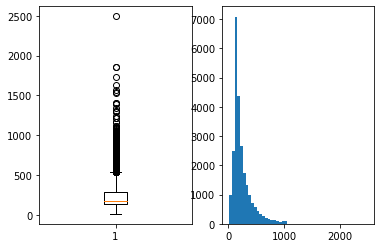

In [ ]:
reviews_length = [len(review) for review in X_train]

print('리뷰의 최대 길이 : {}'.format(np.max(reviews_length)))
print('리뷰의 평균 길이 : {}'.format(np.mean(reviews_length)))

plt.subplot(1,2,1)
plt.boxplot(reviews_length)
plt.subplot(1,2,2)
plt.hist(reviews_length, bins=50)
plt.show()

In [ ]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 레이블에 대한 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

각 레이블에 대한 빈도수:
[[    0     1]
 [12500 12500]]


In [ ]:
word_to_index = imdb.get_word_index()
index_to_word = {}
for key, value in word_to_index.items():
    index_to_word[value+3] = key #전처리 전에 어떤 단어였는지 확인
                                 # imdb.get_word_index()에 저장된 값에 +3을 해야 실제 맵핑되는 정수
                                 # IMDB 리뷰 데이터셋에서 정한 규칙임.

1654784/1641221 [==============================] - 0s 0us/step


In [ ]:
print('빈도수 상위 1등 단어 : {}'.format(index_to_word[4]))

빈도수 상위 1등 단어 : the


In [ ]:
print('빈도수 상위 3938등 단어 : {}'.format(index_to_word[3941]))

빈도수 상위 3938등 단어 : suited


In [ ]:
for index, token in enumerate(("<pad>", "<sos>", "<unk>")): #enumerate를 통해 순서가 있는 자료형을 입력받아 인덱스를 순차적으로 리턴.
  index_to_word[index] = token

print(' '.join([index_to_word[index] for index in X_train[0]])) #각 단어가 정수로 바뀌기 전에 어떤 단어들이었는지 확인

<sos> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and shoul

In [ ]:
import re
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

vocab_size = 10000 #단어집합 크기제한
max_len = 500 #리뷰최대길이

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocab_size)

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [ ]:
embedding_dim = 100
hidden_units = 128

#마지막 시점에서 두 개의 선택지 중 하나를 예측하는 이진 분류 문제를 수행하는 모델
#활성화 함수: 시그모이드 함수
#손실 함수: 크로스 엔트로피 함수
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
#검증 데이터 손실(val_loss)이 증가하면, overfitting 징후이므로 
#val_loss가 4회 증가하면, 정해진 에포크가 도달하지 못하였더라도 학습 조기종료시킴(Early Stopping)

mc = ModelCheckpoint('GRU_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
313/313 [==============================] - ETA: 0s - loss: 0.4708 - acc: 0.7706
Epoch 1: val_acc improved from -inf to 0.84460, saving model to GRU_model.h5
313/313 [==============================] - 184s 581ms/step - loss: 0.4708 - acc: 0.7706 - val_loss: 0.4247 - val_acc: 0.8446
Epoch 2/15
313/313 [==============================] - ETA: 0s - loss: 0.3106 - acc: 0.8788
Epoch 2: val_acc did not improve from 0.84460
313/313 [==============================] - 181s 578ms/step - loss: 0.3106 - acc: 0.8788 - val_loss: 0.3602 - val_acc: 0.8320
Epoch 3/15
313/313 [==============================] - ETA: 0s - loss: 0.2396 - acc: 0.9046
Epoch 3: val_acc improved from 0.84460 to 0.86580, saving model to GRU_model.h5
313/313 [==============================] - 181s 579ms/step - loss: 0.2396 - acc: 0.9046 - val_loss: 0.3264 - val_acc: 0.8658
Epoch 4/15
313/313 [==============================] - ETA: 0s - loss: 0.1915 - acc: 0.9277
Epoch 4: val_acc improved from 0.86580 to 0.89740, saving 

In [ ]:
loaded_model = load_model('GRU_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

782/782 [==============================] - 67s 86ms/step - loss: 0.3056 - acc: 0.8920

 테스트 정확도: 0.8920


In [ ]:
def sentiment_predict(new_sentence):
  # 알파벳과 숫자를 제외하고 모두 제거 및 알파벳 소문자화
  new_sentence = re.sub('[^0-9a-zA-Z ]', '', new_sentence).lower()
  encoded = []

  # 띄어쓰기 단위 토큰화 후 정수 인코딩
  for word in new_sentence.split():
    try :
      # 단어 집합의 크기를 10,000으로 제한.
      if word_to_index[word] <= 10000:
        encoded.append(word_to_index[word]+3)
      else:
      # 10,000 이상의 숫자는 <unk> 토큰으로 변환.
        encoded.append(2)
    # 단어 집합에 없는 단어는 <unk> 토큰으로 변환.
    except KeyError:
      encoded.append(2)

  pad_sequence = pad_sequences([encoded], maxlen=max_len)
  score = float(loaded_model.predict(pad_sequence)) # 예측

  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [ ]:
test_input = "This movie was just way too overrated. The fighting was not professional and in slow motion. I was expecting more from a 200 million budget movie. The little sister of T.Challa was just trying too hard to be funny. The story was really dumb as well. Don't watch this movie if you are going because others say its great unless you are a Black Panther fan or Marvels fan."

sentiment_predict(test_input)

98.96% 확률로 부정 리뷰입니다.


In [ ]:
test_input = " I was lucky enough to be included in the group to see the advanced screening in Melbourne on the 15th of April, 2012. And, firstly, I need to say a big thank-you to Disney and Marvel Studios. \
Now, the film... how can I even begin to explain how I feel about this film? It is, as the title of this review says a 'comic book triumph'. I went into the film with very, very high expectations and I was not disappointed. \
Seeing Joss Whedon's direction and envisioning of the film come to life on the big screen is perfect. The script is amazingly detailed and laced with sharp wit a humor. The special effects are literally mind-blowing and the action scenes are both hard-hitting and beautifully choreographed."

sentiment_predict(test_input)

98.45% 확률로 긍정 리뷰입니다.


🔹 2-(2) **네이버 쇼핑 리뷰 감성 분류**하기
* 네이버 쇼핑 리뷰를 감성에 따라 분류하고, 임의의 리뷰에 대해 감정을 예측해보겠습니다.

📌 [GRU로 네이버 쇼핑 리뷰 감성 분류](https://wikidocs.net/94600)

In [ ]:
# Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 115 (delta 11), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (115/115), 1.27 MiB | 701.00 KiB/s, done.
Resolving deltas: 100% (50/50), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 448 kB 67.9 MB/s 
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2022-05-08 13:14:02--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22e9:9f55, 2406:da00:ff00::22c5:2ef4, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
L

In [ ]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

('ratings_total.txt', <http.client.HTTPMessage at 0x7fd8c9f1fa50>)

In [ ]:
total_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])
print('전체 리뷰 개수 :',len(total_data)) # 전체 리뷰 개수 출력

전체 리뷰 개수 : 200000


In [ ]:
total_data[:5]

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


In [ ]:
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)
total_data[:5]

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


In [ ]:
total_data['ratings'].nunique(), total_data['reviews'].nunique(), total_data['label'].nunique()

(4, 199908, 2)

In [ ]:
total_data.drop_duplicates(subset=['reviews'], inplace=True) # reviews 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :',len(total_data))

총 샘플의 수 : 199908


In [ ]:
print(total_data.isnull().values.any())

False


In [ ]:
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 149931
테스트용 리뷰의 개수 : 49977


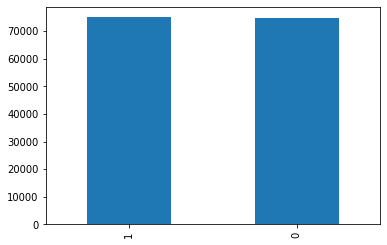

In [ ]:
train_data['label'].value_counts().plot(kind = 'bar')

In [ ]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  74918
1      1  75013


In [ ]:
# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


ratings    0
reviews    0
label      0
dtype: int64


In [ ]:
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 49977


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [ ]:
mecab = Mecab()
print(mecab.morphs('와 이런 것도 상품이라고 차라리 내가 만드는 게 나을 뻔'))

['와', '이런', '것', '도', '상품', '이', '라고', '차라리', '내', '가', '만드', '는', '게', '나을', '뻔']


In [ ]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [ ]:
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [ ]:
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [ ]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [ ]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('네요', 31799), ('는데', 20295), ('안', 19718), ('어요', 14849), ('있', 13200), ('너무', 13058), ('했', 11783), ('좋', 9812), ('배송', 9677), ('같', 8997), ('구매', 8876), ('어', 8869), ('거', 8854), ('없', 8670), ('아요', 8642), ('습니다', 8436), ('그냥', 8355), ('되', 8345), ('잘', 8029), ('않', 7984)]


In [ ]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('좋', 39488), ('아요', 21184), ('네요', 19895), ('어요', 18686), ('잘', 18602), ('구매', 16171), ('습니다', 13320), ('있', 12391), ('배송', 12275), ('는데', 11670), ('했', 9818), ('합니다', 9801), ('먹', 9635), ('재', 9273), ('너무', 8397), ('같', 7868), ('만족', 7261), ('거', 6482), ('어', 6294), ('쓰', 6292)]


긍정 리뷰의 평균 길이 : 13.587751456414221
부정 리뷰의 평균 길이 : 17.029512266744973


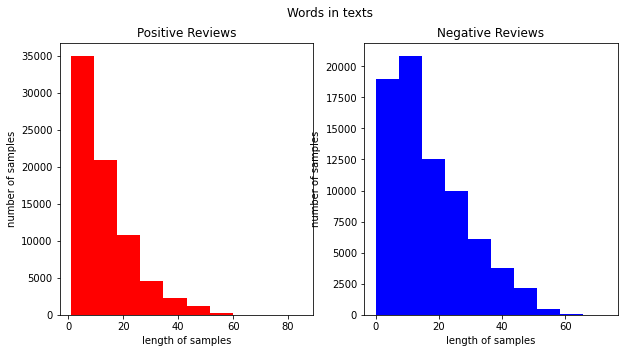

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [ ]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 39998
등장 빈도가 1번 이하인 희귀 단어의 수: 18213
단어 집합에서 희귀 단어의 비율: 45.53477673883694
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.7935688376196857


In [ ]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 21787


In [ ]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
print(X_train[:3])

[[67, 2060, 299, 14259, 263, 73, 6, 236, 168, 137, 805, 2951, 625, 2, 77, 62, 207, 40, 1343, 155, 3, 6], [482, 409, 52, 8530, 2561, 2517, 339, 2918, 250, 2357, 38, 473, 2], [46, 24, 825, 105, 35, 2372, 160, 7, 10, 8061, 4, 1319, 29, 140, 322, 41, 59, 160, 140, 7, 1916, 2, 113, 162, 1379, 323, 119, 136]]


In [ ]:
print(X_test[:3])

[[14, 704, 767, 116, 186, 252, 12], [339, 3904, 62, 3816, 1651], [11, 69, 2, 49, 164, 3, 27, 15, 6, 513, 289, 17, 92, 110, 564, 59, 7, 2]]


리뷰의 최대 길이 : 85
리뷰의 평균 길이 : 15.307541469075774


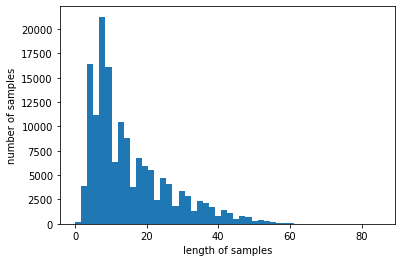

In [ ]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [ ]:
max_len = 80
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.99933302652553


In [ ]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
1875/1875 [==============================] - ETA: 0s - loss: 0.2706 - acc: 0.8981
Epoch 1: val_acc improved from -inf to 0.91680, saving model to best_model.h5
1875/1875 [==============================] - 215s 114ms/step - loss: 0.2706 - acc: 0.8981 - val_loss: 0.2281 - val_acc: 0.9168
Epoch 2/15
1874/1875 [============================>.] - ETA: 0s - loss: 0.2149 - acc: 0.9221
Epoch 2: val_acc improved from 0.91680 to 0.91973, saving model to best_model.h5
1875/1875 [==============================] - 209s 111ms/step - loss: 0.2149 - acc: 0.9221 - val_loss: 0.2298 - val_acc: 0.9197
Epoch 3/15
1874/1875 [============================>.] - ETA: 0s - loss: 0.1983 - acc: 0.9288
Epoch 3: val_acc improved from 0.91973 to 0.92553, saving model to best_model.h5
1875/1875 [==============================] - 208s 111ms/step - loss: 0.1984 - acc: 0.9288 - val_loss: 0.2095 - val_acc: 0.9255
Epoch 4/15
1874/1875 [============================>.] - ETA: 0s - loss: 0.1877 - acc: 0.9332
Epoch 4

In [ ]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1562/1562 [==============================] - 26s 17ms/step - loss: 0.2095 - acc: 0.9246

 테스트 정확도: 0.9246


In [ ]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen = max_len)

  score = float(loaded_model.predict(pad_new))
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [ ]:
sentiment_predict('이 상품 진짜 좋아요... 저는 강추합니다. 대박')

96.60% 확률로 긍정 리뷰입니다.


In [ ]:
sentiment_predict('진짜 배송도 늦고 개짜증나네요. 뭐 이런 걸 상품이라고 만듬?')

99.62% 확률로 부정 리뷰입니다.


In [ ]:
sentiment_predict('판매자님... 너무 짱이에요.. 대박나삼')

97.81% 확률로 긍정 리뷰입니다.


In [ ]:
sentiment_predict('ㅁㄴㅇㄻㄴㅇㄻㄴㅇ리뷰쓰기도 귀찮아')

93.21% 확률로 부정 리뷰입니다.
